In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [31]:
# 2) Data Cleaning & Preparation
# ● Fill missing numerical data with the mean.
# ● Fill missing categorical data with the mode (most common value).
# ● Drop any columns that are entirely missing or have missing sale prices.
# ● Convert categorical variables to indicator (dummy) variables.
# ● Split the data into training (80%) and testing (20%) sets.
# ● Scale the data using StandardScaler from sklearn.

# Load the dataset
df = pd.read_csv("housing-midterm.csv")

# Drop columns that are entirely missing
df.dropna(axis=1, how='all', inplace=True)

# Drop rows with missing SalePrice
df.dropna(subset=['SalePrice'], inplace=True)

# Fill missing numerical data with the mean
numerical_cols = df.select_dtypes(include=[np.number]).columns
df[numerical_cols] = df[numerical_cols].apply(lambda x: x.fillna(x.mean()))

# Fill missing categorical data with the mode
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

# Create a new response variable: log of SalePrice
df['LogSalePrice'] = np.log(df['SalePrice'])

# Drop the original SalePrice column
df.drop(columns=['SalePrice'], inplace=True)

# Convert categorical variables to dummy variables
df = pd.get_dummies(df, drop_first=True)

# Split the data into features and target
X = df.drop(columns=['LogSalePrice'])
y = df['LogSalePrice']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Output the shapes of the processed datasets
print("Training features shape:", X_train_scaled.shape)
print("Testing features shape:", X_test_scaled.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)

Training features shape: (1168, 245)
Testing features shape: (292, 245)
Training target shape: (1168,)
Testing target shape: (292,)


In [32]:
# 3. Forward Stepwise Selection (AIC)
# ● Implement forward stepwise regression using AIC as the selection criterion.
# ● Fit the model on the training data.
# ● Report:
# ○ Which variables are selected?
# ○ Final AIC value of the selected model

def forward_stepwise_selection(X, y):
    # ensure X is a DataFrame and indices align with y (prevent statsmodels index-alignment issues)
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=getattr(X, 'columns', None))
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    initial_features = []
    best_aic = float('inf')
    best_features = None
    remaining_features = list(X.columns)
    
    while remaining_features:
        aic_with_candidates = []
        for feature in remaining_features:
            features_to_test = initial_features + [feature]
            X_train_sm = sm.add_constant(X[features_to_test], has_constant='add')
            model = sm.OLS(y, X_train_sm).fit()
            aic_with_candidates.append((model.aic, feature))
        
        aic_with_candidates.sort()
        best_new_aic, best_feature = aic_with_candidates[0]
        
        if best_new_aic < best_aic:
            best_aic = best_new_aic
            initial_features.append(best_feature)
            remaining_features.remove(best_feature)
            best_features = list(initial_features)
        else:
            break
    
    return best_features, best_aic

# call with the scaled training matrix (function now aligns indices internally)
selected_features, final_aic = forward_stepwise_selection(pd.DataFrame(X_train_scaled, columns=X.columns), y_train)
print("Selected features:", selected_features)
print("Final AIC value:", final_aic)


Selected features: ['OverallQual', 'GrLivArea', 'YearBuilt', 'OverallCond', 'GarageCars', 'BsmtFullBath', 'MSSubClass', 'Fireplaces', 'Condition2_PosN', 'Neighborhood_Crawfor', 'Neighborhood_NridgHt', 'BsmtExposure_No', 'Neighborhood_StoneBr', 'LotArea', 'LotShape_IR3', 'Foundation_PConc', 'Exterior1st_BrkFace', 'BsmtFinType1_Unf', 'YearRemodAdd', 'Functional_Typ', 'BldgType_2fmCon', 'CentralAir_Y', 'Condition1_Norm', 'Neighborhood_Somerst', 'LotConfig_CulDSac', 'BsmtExposure_Gd', 'WoodDeckSF', 'ScreenPorch', 'MSZoning_RL', 'Neighborhood_Edwards', 'PoolArea', 'PoolQC_Gd', 'SaleType_New', 'Functional_Maj2', 'Heating_Grav', 'SaleCondition_Normal', 'SaleCondition_Alloca', 'Foundation_Slab', 'BsmtCond_TA', 'Fence_GdWo', 'Functional_Sev', 'RoofMatl_Tar&Grv', 'Exterior1st_BrkComm', 'BldgType_Twnhs', 'Heating_GasW', 'GarageQual_Gd', 'HouseStyle_SLvl', 'Neighborhood_BrkSide', 'Neighborhood_NoRidge', 'GarageCond_Po', 'SaleType_Oth', 'KitchenAbvGr', 'MSZoning_RH', 'FullBath', 'BsmtQual_Gd', 'Bsm

In [36]:
# 4) Regularization Models
# ● Ridge Regression
# ● Lasso Regression
# ● Elastic Net Regression
# Instructions:
# ● Tune the hyperparameters (e.g., alpha, and l1_ratio for Elastic Net) using cross-validation.
# ● (Hint: Use Pipeline and GridSearchCV from sklearn.)
# ● Report:
# ○ Best hyperparameters for each model.
# ○ Cross-validation MSE.

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

def tune_model(model, param_grid, X, y):
    pipeline = Pipeline([
        ('model', model)
    ])
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X, y)
    best_params = grid_search.best_params_
    best_mse = -grid_search.best_score_
    return best_params, best_mse

# Ridge Regression
ridge_param_grid = {
    'model__alpha': [0.1, 1.0, 10.0, 100.0]
}
best_ridge_params, best_ridge_mse = tune_model(Ridge(), ridge_param_grid, X_train_scaled, y_train)
print("Ridge Regression - Best Hyperparameters:", best_ridge_params)
print("Ridge Regression - Cross-validation MSE:", best_ridge_mse)

# Lasso Regression
lasso_param_grid = {
    'model__alpha': [0.01, 0.1, 1.0, 10.0]
}
best_lasso_params, best_lasso_mse = tune_model(Lasso(), lasso_param_grid, X_train_scaled, y_train)
print("Lasso Regression - Best Hyperparameters:", best_lasso_params)
print("Lasso Regression - Cross-validation MSE:", best_lasso_mse)

# Elastic Net Regression
elasticnet_param_grid = {
    'model__alpha': [0.01, 0.1, 1.0, 10.0],
    'model__l1_ratio': [0.1, 0.5, 0.9]
}
best_elasticnet_params, best_elasticnet_mse = tune_model(ElasticNet(), elasticnet_param_grid, X_train_scaled, y_train)
print("Elastic Net Regression - Best Hyperparameters:", best_elasticnet_params)
print("Elastic Net Regression - Cross-validation MSE:", best_elasticnet_mse)




Ridge Regression - Best Hyperparameters: {'model__alpha': 100.0}
Ridge Regression - Cross-validation MSE: 0.0243738551469212
Lasso Regression - Best Hyperparameters: {'model__alpha': 0.01}
Lasso Regression - Cross-validation MSE: 0.023893676602844457
Elastic Net Regression - Best Hyperparameters: {'model__alpha': 0.1, 'model__l1_ratio': 0.1}
Elastic Net Regression - Cross-validation MSE: 0.0231318242108535


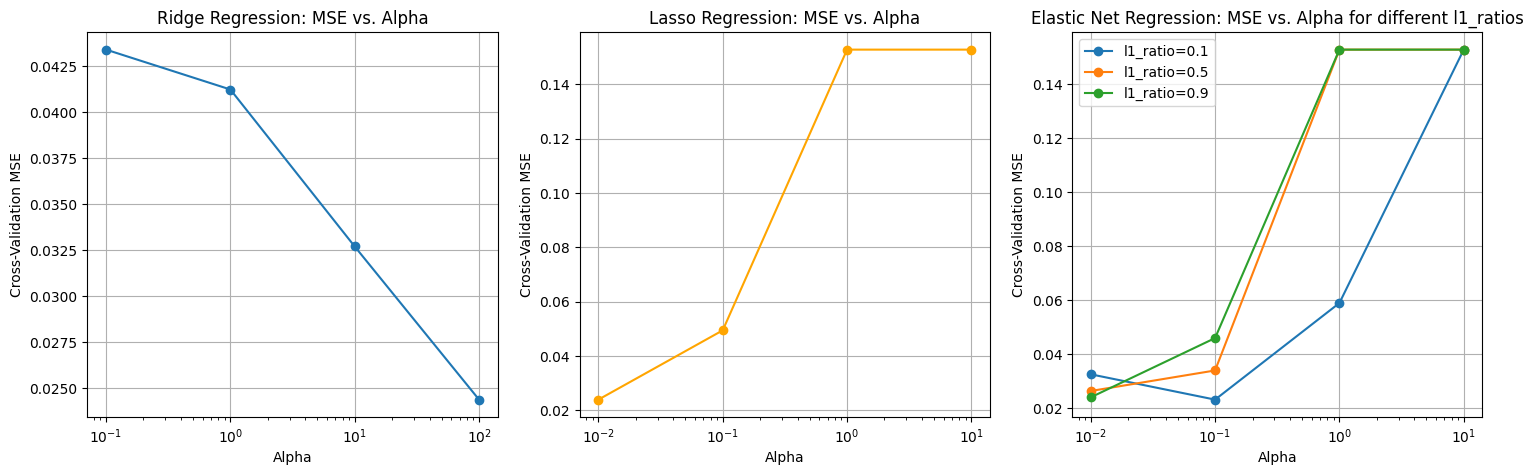

In [42]:
# 5) Hyperparameter Visualization
# ● For each model (Ridge, Lasso, Elastic Net), plot how the cross-validation MSE changes with different hyperparameter values:
# ○ For Ridge and Lasso: plot MSE vs. alpha.
# ○ For Elastic Net: plot MSE vs. alpha for several fixed l1_ratio values.
# ● Use clear labels, titles, and legends to compare performance visually.
# ● Identify the hyperparameter values that minimize the MSE.

import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
# Ridge Regression Hyperparameter Visualization
ridge_alphas = ridge_param_grid['model__alpha']
ridge_mse_values = []
for alpha in ridge_alphas:
    model = Ridge(alpha=alpha)
    neg_mse = -np.mean(cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error'))
    ridge_mse_values.append(neg_mse)
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(ridge_alphas, ridge_mse_values, marker='o')
plt.xlabel("Alpha")
plt.ylabel("Cross-Validation MSE")
plt.title("Ridge Regression: MSE vs. Alpha")
plt.xscale("log")
plt.grid()

# Lasso Regression Hyperparameter Visualization

lasso_alphas = lasso_param_grid['model__alpha']
lasso_mse_values = []
for alpha in lasso_alphas:
    model = Lasso(alpha=alpha)
    neg_mse = -np.mean(cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error'))
    lasso_mse_values.append(neg_mse)
plt.subplot(1, 3, 2)
plt.plot(lasso_alphas, lasso_mse_values, marker='o', color='orange')
plt.xlabel("Alpha")
plt.ylabel("Cross-Validation MSE")
plt.title("Lasso Regression: MSE vs. Alpha")
plt.xscale("log")
plt.grid()

# Elastic Net Regression Hyperparameter Visualization
plt.subplot(1, 3, 3)
elasticnet_alphas = elasticnet_param_grid['model__alpha']
l1_ratios = elasticnet_param_grid['model__l1_ratio']
for l1_ratio in l1_ratios:
    elasticnet_mse_values = []
    for alpha in elasticnet_alphas:
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        neg_mse = -np.mean(cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error'))
        elasticnet_mse_values.append(neg_mse)
    
    plt.plot(elasticnet_alphas, elasticnet_mse_values, marker='o', label=f'l1_ratio={l1_ratio}')
plt.xlabel("Alpha")
plt.ylabel("Cross-Validation MSE")
plt.title("Elastic Net Regression: MSE vs. Alpha for different l1_ratios")
plt.xscale("log")
plt.grid()
plt.legend()
plt.show()


In [10]:
# Test Set Evaluation
# ● Compute the Test MSE for Ridge, Lasso, and Elastic Net models.
# ● Which model performs best on the test data?

from sklearn.metrics import mean_squared_error
# Ridge Regression Test MSE
best_ridge_model = Ridge(**{k.replace('model__', ''): v for k, v in best_ridge_params.items()})
best_ridge_model.fit(X_train_scaled, y_train)
ridge_test_preds = best_ridge_model.predict(X_test_scaled)
ridge_test_mse = mean_squared_error(y_test, ridge_test_preds)
print(f"Ridge Regression Test MSE: {ridge_test_mse}")

# Lasso Regression Test MSE
best_lasso_model = Lasso(**{k.replace('model__', ''): v for k, v in best_lasso_params.items()})
best_lasso_model.fit(X_train_scaled, y_train)
lasso_test_preds = best_lasso_model.predict(X_test_scaled)
lasso_test_mse = mean_squared_error(y_test, lasso_test_preds)
print(f"Lasso Regression Test MSE: {lasso_test_mse}")

# Elastic Net Regression Test MSE
best_elasticnet_model = ElasticNet(**{k.replace('model__', ''): v for k, v in best_elasticnet_params.items()})
best_elasticnet_model.fit(X_train_scaled, y_train)
elasticnet_test_preds = best_elasticnet_model.predict(X_test_scaled)
elasticnet_test_mse = mean_squared_error(y_test, elasticnet_test_preds)
print(f"Elastic Net Regression Test MSE: {elasticnet_test_mse}")

# Identify the best model based on Test MSE
test_mse_results = {
    'Ridge': ridge_test_mse,
    'Lasso': lasso_test_mse,
    'Elastic Net': elasticnet_test_mse
}
best_model_name = min(test_mse_results, key=test_mse_results.get)
print(f"Best model on test data: {best_model_name} with Test MSE: {test_mse_results[best_model_name]}")


Ridge Regression Test MSE: 0.020992980472355774
Lasso Regression Test MSE: 0.021656493398050255
Elastic Net Regression Test MSE: 0.022315511957559635
Best model on test data: Ridge with Test MSE: 0.020992980472355774


In [15]:
# 7) Coefficient Comparison
# ● Compare the coefficients from each of the three regularization models.
# ● Are there variables that are consistently important across all models?
ridge_coeffs = pd.Series(best_ridge_model.coef_, index=X.columns, name='Ridge Coefficients')
lasso_coeffs = pd.Series(best_lasso_model.coef_, index=X.columns, name='Lasso Coefficients')
elasticnet_coeffs = pd.Series(best_elasticnet_model.coef_, index=X.columns, name='Elastic Net Coefficients')


# Combine coefficients into a DataFrame
coeff_df = pd.DataFrame({
    'Ridge': ridge_coeffs,
    'Lasso': lasso_coeffs,
    'ElasticNet': elasticnet_coeffs
})

# Compute average absolute coefficient across models
coeff_df['avg_abs'] = coeff_df[['Ridge', 'Lasso', 'ElasticNet']].abs().mean(axis=1)

# Sort by average absolute coefficient
top_vars = coeff_df.sort_values(by='avg_abs', ascending=False).head(15)

print("Top 15 most important variables across all models:")
print(top_vars)


Top 15 most important variables across all models:
                         Ridge     Lasso  ElasticNet   avg_abs
OverallQual           0.057389  0.110196    0.090843  0.086143
GrLivArea             0.043679  0.104857    0.069625  0.072721
GarageCars            0.032517  0.052286    0.039924  0.041576
YearBuilt             0.027434  0.034042    0.023151  0.028209
OverallCond           0.032700  0.026725    0.024391  0.027939
Fireplaces            0.021273  0.021852    0.025202  0.022775
YearRemodAdd          0.019473  0.024375    0.023840  0.022563
CentralAir_Y          0.020880  0.018258    0.019228  0.019455
BsmtFullBath          0.018176  0.021464    0.018057  0.019233
TotRmsAbvGrd          0.022200  0.007879    0.024568  0.018216
Neighborhood_NridgHt  0.024920  0.014666    0.014923  0.018170
Condition2_PosN      -0.022108 -0.015038   -0.011728  0.016291
Neighborhood_Crawfor  0.020629  0.012719    0.013032  0.015460
1stFlrSF              0.030047  0.001902    0.014179  0.015376
Bsmt

c:\Users\rka304\AppData\Local\anaconda3\envs\ai_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.551e-02, tolerance: 1.428e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\rka304\AppData\Local\anaconda3\envs\ai_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.196e-02, tolerance: 1.428e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\rka304\AppData\Local\anaconda3\envs\ai_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the

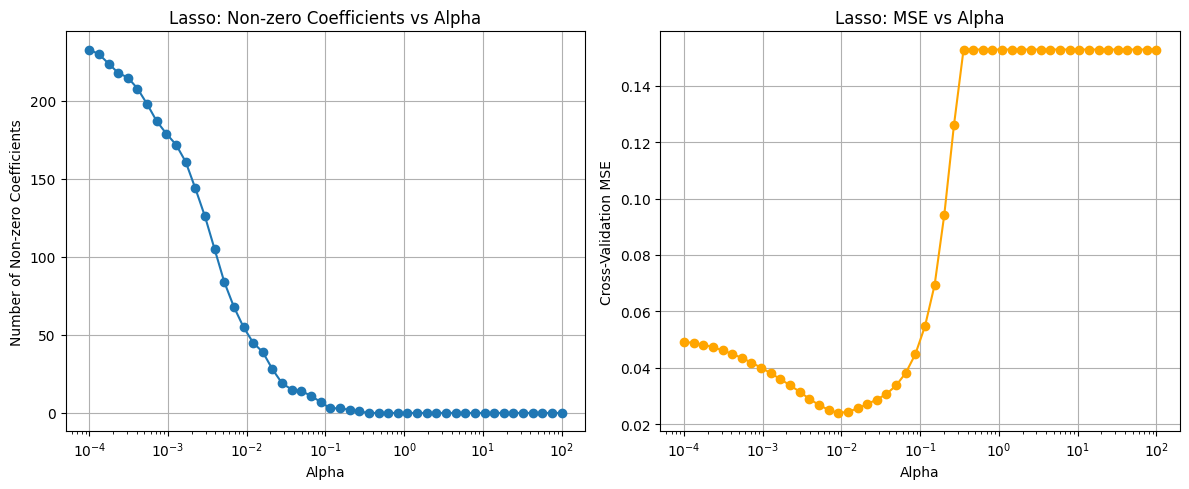

In [16]:
# 8) Effect of Regularization on Lasso
# ● Examine how the number of non-zero coefficients in the Lasso model changes as you vary alpha.
# ● Plot the cross-validation MSE vs. alpha for Lasso.
# (Hint: Use a log scale for alpha.)
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
lasso_alphas = np.logspace(-4, 2, 50)
non_zero_counts = []
mse_values = []    
for alpha in lasso_alphas:
    model = Lasso(alpha=alpha)
    model.fit(X_train_scaled, y_train)
    non_zero_counts.append(np.sum(model.coef_ != 0))
    neg_mse = -np.mean(cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error'))
    mse_values.append(neg_mse)

# Plot Non-zero Coefficients vs Alpha
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(lasso_alphas, non_zero_counts, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Number of Non-zero Coefficients')
plt.title('Lasso: Non-zero Coefficients vs Alpha')
plt.grid()

# Plot MSE vs Alpha
plt.subplot(1, 2, 2)
plt.plot(lasso_alphas, mse_values, marker='o', color='orange')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Cross-Validation MSE')
plt.title('Lasso: MSE vs Alpha')
plt.grid()
plt.tight_layout()
plt.show()

In [43]:
# 9) Compare to Stepwise Selection
# ● Compare the best regularization model to your forward stepwise selection model from Question 3.
# ● Which model performs best on the test data?
# ● Do the same variables appear important in both models?

# Get the best regularization model based on test MSE
best_regularization_model_name = best_model_name
print(f"Best regularization model on test data: {best_regularization_model_name} with Test MSE: {test_mse_results[best_regularization_model_name]}")
# Fit the forward stepwise selection model on the test data
X_test_sm = sm.add_constant(X_test_scaled[:, [X.columns.get_loc(col) for col in selected_features]], has_constant='add')
stepwise_model = sm.OLS(y_test, X_test_sm).fit()
stepwise_test_preds = stepwise_model.predict(X_test_sm)
stepwise_test_mse = mean_squared_error(y_test, stepwise_test_preds)
print(f"Forward Stepwise Selection Test MSE: {stepwise_test_mse}")
if stepwise_test_mse < test_mse_results[best_regularization_model_name]:
    print("Forward Stepwise Selection performs better on the test data.")
else:
    print(f"{best_regularization_model_name} performs better on the test data.")

# Compare important variables
print("Variables selected by Forward Stepwise Selection:")
print(selected_features)
# Identify important variables from the best regularization model
if best_regularization_model_name == 'Ridge':
    important_vars = ridge_coeffs[ridge_coeffs.abs() > 1e-5].index.tolist()
elif best_regularization_model_name == 'Lasso':
    important_vars = lasso_coeffs[lasso_coeffs.abs() > 1e-5].index.tolist()
elif best_regularization_model_name == 'Elastic Net':
    important_vars = elasticnet_coeffs[elasticnet_coeffs.abs() > 1e-5].index.tolist()
print(f"Important variables from {best_regularization_model_name}:")
print(important_vars)

Best regularization model on test data: Ridge with Test MSE: 0.020992980472355774
Forward Stepwise Selection Test MSE: 0.006125444807998936
Forward Stepwise Selection performs better on the test data.
Variables selected by Forward Stepwise Selection:
['OverallQual', 'GrLivArea', 'YearBuilt', 'OverallCond', 'GarageCars', 'BsmtFullBath', 'MSSubClass', 'Fireplaces', 'Condition2_PosN', 'Neighborhood_Crawfor', 'Neighborhood_NridgHt', 'BsmtExposure_No', 'Neighborhood_StoneBr', 'LotArea', 'LotShape_IR3', 'Foundation_PConc', 'Exterior1st_BrkFace', 'BsmtFinType1_Unf', 'YearRemodAdd', 'Functional_Typ', 'BldgType_2fmCon', 'CentralAir_Y', 'Condition1_Norm', 'Neighborhood_Somerst', 'LotConfig_CulDSac', 'BsmtExposure_Gd', 'WoodDeckSF', 'ScreenPorch', 'MSZoning_RL', 'Neighborhood_Edwards', 'PoolArea', 'PoolQC_Gd', 'SaleType_New', 'Functional_Maj2', 'Heating_Grav', 'SaleCondition_Normal', 'SaleCondition_Alloca', 'Foundation_Slab', 'BsmtCond_TA', 'Fence_GdWo', 'Functional_Sev', 'RoofMatl_Tar&Grv', 'Ext